The NBA playoffs are coming soon and the brackets are almost set. This notebook aims to make predictions for these playoffs.

This project delivers value by:
- revealing indicators of success that tend to appear in the NBA
- providing data to identify strategies that need to be adjusted

In [1]:
import sqlalchemy
from os import environ

import numpy as np
import pandas as pd

The data used in this projects are the traditional team box scores during the regular and postseasons from the 1989-90 to 2020-21. These box scores represent the team's sum (in the case of percentages, the total percentages) of each statistic in a game.

Data was sourced from the NBA's official website: https://www.nba.com/stats/teams/boxscores/

The data is stored locally in a MySQL database and is imported as follows:

In [2]:
engine = sqlalchemy.create_engine("mariadb+mariadbconnector://"+environ.get("USER")+\
                                  ":"+environ.get("PSWD")+"@127.0.0.1:3306/nba")

In [3]:
command = "SELECT Teams.Name AS Team, Team_box_scores.* FROM Team_box_scores"+\
" INNER JOIN Teams ON Team_box_scores.Team_ID = Teams.ID "

df = pd.read_sql(command,engine,parse_dates='Game_day')

In [4]:
drop_columns = ['Team_ID']
df.drop(columns=drop_columns,inplace = True)

In [5]:
def made_playoffs(df):
    # Season_type will be used to differentiate regular season from playoffs.
    
    df["Season_type"] = df["Game_ID"].str.slice(0,3) # first three digits represent the season type
    df["Year"] = df["Game_ID"].str.slice(3,5) # 4th and 5th digit represent year the season started
    df['Playoffs'] = True
    
    # gdf.index is a tuple of size 3 of the format: (Team, season_type, year)
    gdf = df.groupby(['Team','Season_type','Year']).count()

    # Change Playoffs variable to False if there is no playoff data for that team that year.
    for t,s,y in gdf.index:
        if(s=='004'):
            l = gdf.loc[t].loc[s].index
            df.loc[df['Team']==t,"Playoffs"] = df.loc[df['Team']==t,"Playoffs"].where(df["Year"].isin(l),False)

    # Now that the playoff status has been established, the temporary variables can be removed

    df = df.loc[df['Season_type']=='002']
    drop_cols = ['Season_type','Year']
    df.drop(columns = drop_cols,inplace=True)
    
    return df

In [6]:
df = made_playoffs(df)

/home/blunt/.local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Basic exploration

The data is relatively clean with 103 null values for the variable P3P (3P%) which means that there were 103 games over the last 33 years in which a team did not attempt 3 point shots. The null value is a result of dividing FGM by FGA which are both 0. As a result, in this case null and 0 are semantically the same thing: that no 3 point shots were made. So the null values can be can be replaced by 0. The same can be done for incoming FGP, FTP. This will be implemented in the data cleaning portion of this analysis.

In [7]:
df.shape

(74454, 25)

In [8]:
df.isna().sum()

Team          0
Game_ID       0
Matchup       0
Game_day      0
Result        0
MINS          0
PTS           0
FGM           0
FGA           0
FGP           0
PM3           0
PA3           0
P3P         103
FTM           0
FTA           0
FTP           0
OREB          0
DREB          0
REB           0
AST           0
TOV           0
STL           0
BLK           0
PF            0
Playoffs      0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74454 entries, 0 to 79503
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Team      74454 non-null  object        
 1   Game_ID   74454 non-null  object        
 2   Matchup   74454 non-null  object        
 3   Game_day  74454 non-null  datetime64[ns]
 4   Result    74454 non-null  object        
 5   MINS      74454 non-null  int64         
 6   PTS       74454 non-null  int64         
 7   FGM       74454 non-null  int64         
 8   FGA       74454 non-null  int64         
 9   FGP       74454 non-null  float64       
 10  PM3       74454 non-null  int64         
 11  PA3       74454 non-null  int64         
 12  P3P       74351 non-null  float64       
 13  FTM       74454 non-null  int64         
 14  FTA       74454 non-null  int64         
 15  FTP       74454 non-null  float64       
 16  OREB      74454 non-null  int64         
 17  DREB      74

Below is the histogram for each numeric variable

In [10]:
import matplotlib.pyplot as plt
df.hist(bins = 100,figsize=(30,15),grid=False)
plt.show()

<Figure size 3000x1500 with 20 Axes>

With the exception of the Minutes played, all other numeric statistics are roughly normally distributed. This pattern is typical throughout basketball (from team performance to individual performance) and it is this property that that will be useful for a number of machine learning methods.

It must be noted that the PM3 (3PM) and PA3 (3PA) variables are slightly right skewed. This indicates that historically, there are teams that attempted and made 3 point shots. With the rise in popularity of the 3 point shot in recent years, I suspect that these distributions are likely to become more centred and resemble a normal distribution.

The Game_day variable shows a cyclical pattern to the NBA season.

Minutes played will not follow a normal distribution because most games typically end in regulation and increasingly less every subsequent overtime period. It may be difficult to use minutes played as a predictor to make the playoffs.

# Test set allocation
Best practice dictates that a test set must now be created and unseen the until models can be tested.

Since there are a large number of records $\approx$ 75K, the data can be randomly sampled. The test size will be 20% of the data. This will be used to evaluate the final model. For reprducability, the random seed will be 10.

Model selection will be done using cross-validation.

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
features = ['Result', 'MINS', 'PTS', 'FGM', 'FGA', 'FGP', 'PM3', 'PA3', 'P3P','FTM','FTA',
              'FTP', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK','PF']
dependent = ['Playoffs']

In [13]:
def split_train_test(df, SEED = 10, test_size=0.2):
    train,test = train_test_split(df,random_state=SEED,test_size=test_size)
    
    return train, test

In [14]:
train, test = split_train_test(df)

# Exploratory analysis

First, let's explore the correlations between the variables. One of the assumptions for logistic regression is that predictor variables must be independent of each other. It will be important to exclude the strongly correlated variables from the the input features.

In [15]:
corr_matrix = train.corr()

In [16]:
def plot_correlation_matrix(corr_matrix):
    precision = 2
    cmap = 'seismic' #'coolwarm'
    
    return corr_matrix.style.background_gradient(cmap=cmap,vmin=-1,vmax=1).format(precision=precision)

In [17]:
plot_correlation_matrix(corr_matrix)

,MINS,PTS,FGM,FGA,FGP,PM3,PA3,P3P,FTM,FTA,FTP,OREB,DREB,REB,AST,TOV,STL,BLK,PF,Playoffs
MINS,1.00,0.19,0.15,0.27,-0.04,0.05,0.06,0.00,0.10,0.11,0.00,0.08,0.16,0.19,0.07,0.07,0.03,0.06,0.17,0.00
PTS,0.19,1.00,0.85,0.40,0.68,0.42,0.26,0.34,0.32,0.27,0.19,-0.00,0.21,0.17,0.59,-0.12,0.12,0.06,0.10,0.12
FGM,0.15,0.85,1.00,0.54,0.74,0.23,0.10,0.24,-0.14,-0.15,0.01,0.04,0.16,0.16,0.67,-0.14,0.12,0.06,0.02,0.08
FGA,0.27,0.40,0.54,1.00,-0.16,0.15,0.24,-0.09,-0.21,-0.22,-0.01,0.49,0.18,0.46,0.26,-0.25,0.14,0.03,0.03,-0.05
FGP,-0.04,0.68,0.74,-0.16,1.00,0.16,-0.07,0.35,0.01,-0.00,0.02,-0.33,0.04,-0.18,0.57,0.04,0.03,0.05,0.00,0.13
PM3,0.05,0.42,0.23,0.15,0.16,1.00,0.86,0.52,-0.16,-0.19,0.05,-0.24,0.21,0.03,0.24,-0.09,-0.06,-0.04,-0.11,0.06
PA3,0.06,0.26,0.10,0.24,-0.07,0.86,1.00,0.11,-0.17,-0.20,0.05,-0.18,0.25,0.09,0.09,-0.11,-0.06,-0.05,-0.13,0.04
P3P,0.00,0.34,0.24,-0.09,0.35,0.52,0.11,1.00,-0.04,-0.05,0.03,-0.17,0.03,-0.08,0.26,-0.01,-0.02,0.01,-0.01,0.05
FTM,0.10,0.32,-0.14,-0.21,0.01,-0.16,-0.17,-0.04,1.00,0.93,0.34,0.06,0.02,0.06,-0.09,0.05,0.07,0.05,0.23,0.06
FTA,0.11,0.27,-0.15,-0.22,-0.00,-0.19,-0.20,-0.05,0.93,1.00,-0.02,0.11,0.01,0.08,-0.11,0.07,0.09,0.06,0.25,0.05


It can be seen that there are a number of positive correlations, most of them regarding the scoring aspect of the game such as field goals, points, assists and free throws. There are a few negatively correlated relationships but they appear to be weak.

In [18]:
def make_boolean(df,true_value, column):
    df[column] = df[column]==true_val
    
    return df

Since teams are ranked within their conference, it could be useful to include the conference a team competes in. If there are any significant diifferences between the conferences, this difference would not be relevant to predict teams in different conferences making the playoffs but could be useful in determining the odds of the NBA finals in which the two conferences converge.

So the function below creates a new column called 'West' which will be a boolean varaible that indicates whether the team is in the western conference or not.

In [19]:
def include_conference(df):
    west = ['NOP','UTA', 'MEM','PHX', 'POR', 'SAC', 'SAS', 'OKC','DAL', 'DEN', 'GSW', 'HOU','LAC', 'LAL','MIN']
    
    df['West'] = df['Team'].isin(west)
    
    return df

There are a few statitics that can be derived with traditional box score stats including possessions (Poss), points per possession (PPP), offensive rebound percentage (OREB%), free throw rate (FTR), assist-turnover ratio (ATR) and effective field goal percentage (eFG).

In [36]:
def add_new_features(df):
    df["Poss"] = df["FGA"] - df["TOV"] + df["OREB"] + 0.44*df["FTA"]
    df["PPP"] = df["PTS"]/df["Poss"]
    df['OREB%'] = df["OREB"]/(df["FGA"] -df["FGM"])
    df['ATR'] = df["AST"]/df["TOV"]
    df['FTR'] = df["FTA"]/df["FGA"]
    df['eFG'] = 100*(df['FGM']+.5*df['PM3'])/df['FGA']
    
    df = include_conference(df)
    
    return df

In [37]:
train = add_new_features(train)

In [38]:
idx = ['PTS','FGM','FGA','FGP','PM3','PA3','FTM','FTA','FTP','Poss',"PPP",'OREB%','ATR','FTR','eFG']

In [39]:
corr_matrix = train.corr()
plot_correlation_matrix(corr_matrix.loc[idx,idx])

,PTS,FGM,FGA,FGP,PM3,PA3,FTM,FTA,FTP,Poss,PPP,OREB%,ATR,FTR,eFG
PTS,1.00,0.85,0.40,0.68,0.42,0.26,0.32,0.27,0.19,0.38,0.52,0.10,0.40,0.13,0.72
FGM,0.85,1.00,0.54,0.74,0.23,0.10,-0.14,-0.15,0.01,0.37,0.39,0.13,0.46,-0.29,0.70
FGA,0.40,0.54,1.00,-0.16,0.15,0.24,-0.21,-0.22,-0.01,0.85,-0.43,0.19,0.33,-0.48,-0.14
FGP,0.68,0.74,-0.16,1.00,0.16,-0.07,0.01,-0.00,0.02,-0.23,0.80,0.00,0.28,0.04,0.94
PM3,0.42,0.23,0.15,0.16,1.00,0.86,-0.16,-0.19,0.05,-0.01,0.37,-0.27,0.19,-0.21,0.48
PA3,0.26,0.10,0.24,-0.07,0.86,1.00,-0.17,-0.20,0.05,0.08,0.15,-0.30,0.13,-0.24,0.23
FTM,0.32,-0.14,-0.21,0.01,-0.16,-0.17,1.00,0.93,0.34,0.13,0.16,0.15,-0.09,0.89,-0.04
FTA,0.27,-0.15,-0.22,-0.00,-0.19,-0.20,0.93,1.00,-0.02,0.16,0.09,0.20,-0.11,0.95,-0.06
FTP,0.19,0.01,-0.01,0.02,0.05,0.05,0.34,-0.02,1.00,-0.04,0.20,-0.12,0.03,-0.01,0.04
Poss,0.38,0.37,0.85,-0.23,-0.01,0.08,0.13,0.16,-0.04,1.00,-0.58,0.44,0.40,-0.10,-0.25


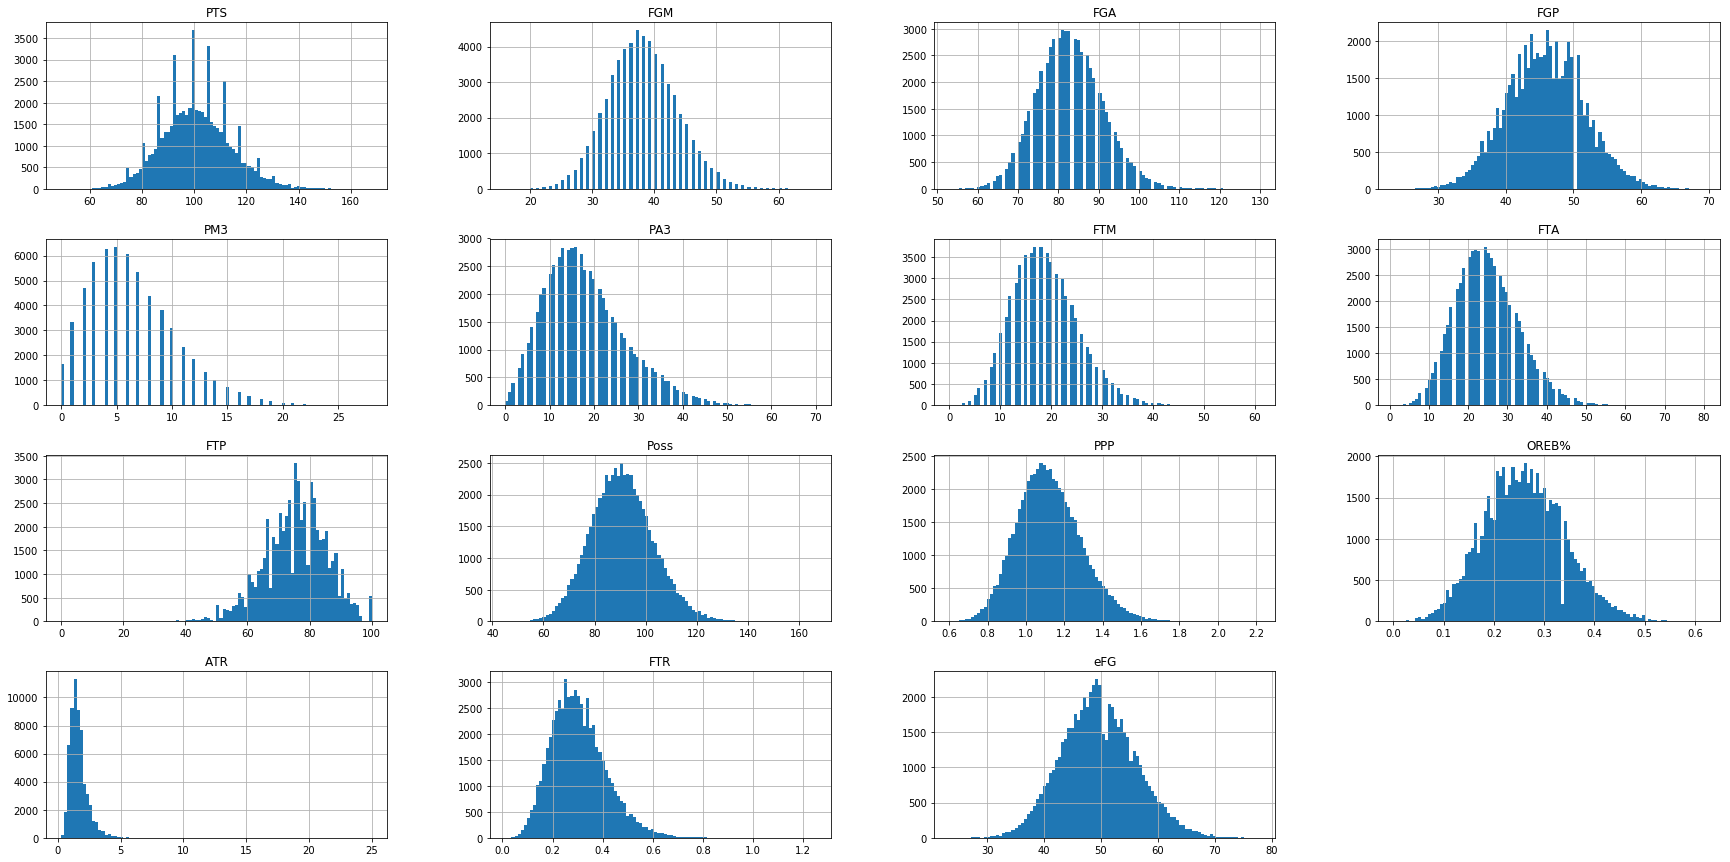

In [40]:
train[idx].hist(bins=100,figsize=(30,15))
plt.show()

In [ ]:
df.fillna(value={'P3P':0},inplace=True)